In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt',a 'r').read().splitlines()
print(len(words))
words[:8]

32033


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


### Recreating the 2 Layer MLP like before

In [7]:
class Linear:
    def __init__(self,fan_in,fan_out, bias=True):
        self.weight = torch.randn((fan_in,fan_out))/fan_in**0.5 # using kaiming initialisation by default
        self.bias = torch.zeros(fan_out) if bias else None


    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight]+ ([] if self.bias is None else [self.bias])
    


class BatchNorm1d:
    def __init__(self, dim, eps = 1e-05, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters trained with backprop
        self.gain  = torch.ones(dim)
        self.bias = torch.zeros (dim)

        # buffers trained with a running 'momentum' update
        self.mean_running = torch.zeros(dim)
        self.var_running = torch.ones(dim)


    def __call__(self,x): #pytorch won't have a .out atrribute, we are creating it so we can track/plot the statistics later

        if self.training:
            xmean = x.mean(0,keepdim=True) # using the batch mean/std during training
            xvar = x.var(0,keepdim=True) # note, using var, not std coz we need to add epsilon later
        else:
            xmean = self.mean_running # using the running mean/std if not training
            xvar  = self.var_running 

        xhat = (x - xmean)/ torch.sqrt(xvar + self.eps)
        self.out = self.gain * xhat + self.bias

        if self.training:
            with torch.no_grad(): # used during inference, but calculated during training, nothing to optimise here hence using the context manager
                self.mean_running = (1-self.momentum)*self.mean_running + self.momentum *xmean 
                self.std_running = (1-self.momentum)*self.var_running + self.momentum * xvar 
        
        return self.out
    
    def parameters(self,):
        return [self.gain, self.bias]
    
    

class Tanh: # just calls torch.tanh on an input tensor, no parameters
    def __call__ (self,x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self,):
        return []
    
class Embedding:
    def __init__(self,num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings,embedding_dim))

    def __call__(self,IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self,x):
        self.out = x.view(x.shape[0],-1)
        return self.out
    def parameters(self):
        return []



## Implementing pytorch like container - Sequential to organise the layers better

In [8]:
class Sequential:
    def __init__(self,layers):
        self.layers = layers
    
    def __call__(self,x):
        for layer in self.layers:
            x= layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get params of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [9]:
torch.manual_seed(42);

In [10]:
n_embd = 10 # dimensionality of char embedding vectors 
n_hidden = 200 # number of neurons in the hidden layer of MLP


model = Sequential([
    Embedding(vocab_size,n_embd),
    Flatten(),
    Linear(n_embd*block_size,n_hidden,bias=False ), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden,vocab_size ),   
])

# parameter init 
with torch.no_grad():
    model.layers[-1].weight *=0.1 # making last layer less confident

parameters =  model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


In [11]:
# same optimization as last time?
max_steps = 200000
batch_size = 32
lossi = []

In [12]:
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function


    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2418
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


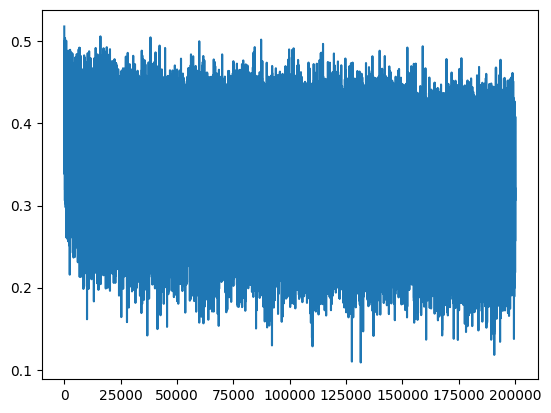

In [13]:
plt.plot(lossi)

In [14]:
# put layers in eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [15]:
@torch.no_grad() # this decorator disables gradient tracking for operations done by the following function, almost like all the tensor created here have requires_grad= False, we can also use a context manager with torch.nograd
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2795968055725098
val 2.3577370643615723


In [16]:
# sampling
for _ in range(20):
    out =[]
    context = [0]*block_size # initialize with all ...
    while True:
        logits =  model(torch.tensor([context]))
        probs = F.softmax(logits,dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:]+[ix]
        out.append(ix)
        # if we sample the '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

iveah.
grace.
tylo.
maxton.
joem.
addyn.
abdula.
jolivious.
pieseino.
gracllow.
jaxtevanna.
pawrishmiah.
fina.
cara.
quindy.
jacque.
tell.
praelynn.
jose.
brita.


FIXING THE LOSS plot - 
Since batch size if very small at 32, we can get very lucky or very unlucky with the loss in any of these batches, hence it creates a thick loss plot
Instead lets take the mean of loss for every 1000 iterations and plot that, giving much better summary of the loss

Note the steep decline near 150. 
This is caused becaused we decreased the learning rate at 150000 iterations
It means that the decay in learning rate was able to subtract a lot of energy out of the system and allowed us to settle into sort of a local minimum during optimisation 


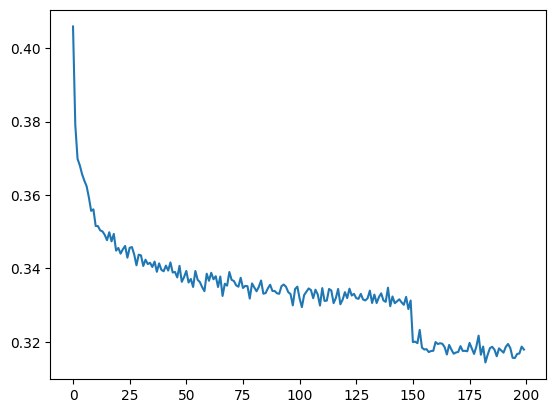

In [17]:
averaged_loss = torch.tensor(lossi).view(-1,1000).mean(1)
plt.plot(averaged_loss)

explanation = """Note the steep decline near 150. \nThis is caused becaused we decreased the learning rate at 150000 iterations
It means that the decay in learning rate was able to subtract a lot of energy out of the system and allowed us to settle into sort of a local minimum during optimisation """

print(explanation)

### Because the train and validation loss are very close to each other, we may assume that there is still pontential to improve the model, maybe by utilising a better/bigger archticture or context